In [1]:
import os
import SimpleITK as sitk
import six
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
import PyQt5
import numpy as np
import os, glob
import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import keyboard
import nibabel as nib
from scipy import ndimage
from radiomics import featureextractor 
from radiomics import imageoperations
from radiomics import glcm
from radiomics import base, cMatrices
from collections import OrderedDict
from IPython.core.display import display, HTML
from util import IndexTracker
import nrrd

%matplotlib widget

In [2]:
# Load QSM and segmentation
seg = nib.load('D:/Elements Drive 2020/datasets/CBIC_QSM/AD_p etc/seg.nii.gz')
qsm = nib.load('D:/Elements Drive 2020/datasets/CBIC_QSM/AD_p etc/qsm_p.nii')

# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
# Partition mask
seg_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) > 0
rsn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 1
lsn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 2
rrn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 3
lrn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 4
lstn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 5
rstn_mask = np.rot90(np.swapaxes(np.dstack(seg.get_fdata()),0,2)) == 6



In [3]:
# Convert to SITK images
roi_masks = [rsn_mask,lsn_mask,rrn_mask,lrn_mask,lstn_mask,rstn_mask]
qsm_np = np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))
qsm_sitk = sitk.GetImageFromArray(qsm_np) 
for i in range(len(roi_masks)):
    seg_sitk = sitk.GetImageFromArray(np.float64(roi_masks[i]))

# Prepare extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
featureVector0 = extractor.execute(qsm_sitk,seg_sitk)

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


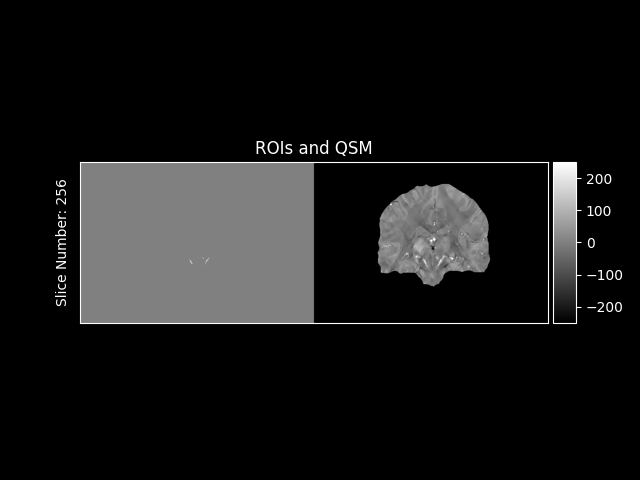

In [4]:
# Combine QSM and mask
y0 = np.hstack((np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))*seg_mask,np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))))
# Apply window level
y0[y0<m1]=m1
y0[y0>m2]=m2
# Plot
fig0,ax0 = plt.subplots(1,1)
tracker0 = IndexTracker(ax0,y0)
fig0.canvas.mpl_connect('scroll_event', tracker0.onscroll)
ax0.set_title('ROIs and QSM');

	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 56ff1b286e23a1c84c52d08a35ae32e6d31103b7
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (512, 512, 352)
	diagnostics_Image-original_Mean: -29089.922570770435
	diagnostics_Image-original_Minimum: -32768.0
	diagnostics_Image-original_Maximum: 2536.0
	dia

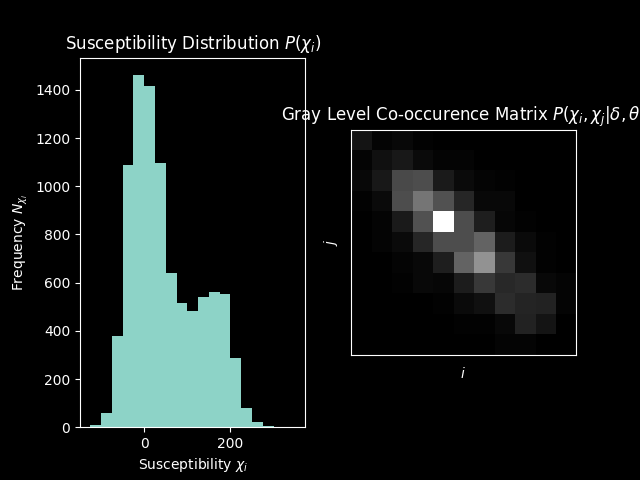

In [8]:
for key, value in six.iteritems(featureVector0):
    print("\t%s: %s" %(key, value))
    if key == 'diagnostics_Mask-original_BoundingBox':
        lims = value
        # Assuming kernel radius of 3, slide of 1, and padding of 0
        sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
        sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)
        
qsm_crop_sitk = qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1]
seg_crop_sitk = seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1]
fig1,ax1 = plt.subplots(1,2)
ax1[0].hist(qsm_crop_sitk,imageoperations.getBinEdges(qsm_crop_sitk))
ax1[0].set_title('Susceptibility Distribution $P(\chi_i)$')
ax1[0].set_xlabel('Susceptibility $\chi_i$')
ax1[0].set_ylabel('Frequency $N_{\chi_i}$')

g = glcm.RadiomicsGLCM(qsm_crop_sitk, seg_crop_sitk)
ax1[1].imshow(np.squeeze(g._calculateMatrix())[:,:,6])
ax1[1].set_title('Gray Level Co-occurence Matrix $P(\chi_i,\chi_j|\delta,\\theta)$')
ax1[1].set_xticks([])
ax1[1].set_yticks([])
ax1[1].set_xlabel('$i$')
ax1[1].set_ylabel('$j}$')
plt.set_cmap('gray')
plt.show()
fig1.suptitle('Right subthalamic nucleus $1^{st}$ and $2^{nd}$ order statistics');

In [7]:

# Extract 1st order features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
features1 = OrderedDict()
featureVector1 = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)
result1 = features1
Finalresult=six.iteritems(result1)

for key, value in six.iteritems(featureVector1):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)
        

	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelBased': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 56ff1b286e23a1c84c52d08a35ae32e6d31103b7
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (512, 512, 352)
	diagnostics_Image-original_Mean: -29089.922570770435
	diagnostics_Image-original_Minimum: -32768.0
	diagnostics_Image-original_

In [9]:
qsm_crop_sitk = qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1]
seg_crop_sitk = seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1]
seg_data, seg_header = nrrd.read('qsm_crop.nrrd')
grad_sitk = sitk.Gradient(qsm_crop_sitk)
sitk.WriteImage(grad_sitk, 'grad' + '.nrrd',True)

grad_data, grad_header = nrrd.read('grad.nrrd')
mean, mean_header = nrrd.read('original_firstorder_Mean.nrrd')
median, median_header = nrrd.read('original_firstorder_Median.nrrd')
variance, variance_header = nrrd.read('original_firstorder_Variance.nrrd')
skewness, skewness_header = nrrd.read('original_firstorder_Skewness.nrrd')
kurtosis, kurtosis_header = nrrd.read('original_firstorder_Kurtosis.nrrd')
energy, energy_header = nrrd.read('original_firstorder_Energy.nrrd')
entropy, entropy_header = nrrd.read('original_firstorder_Entropy.nrrd')


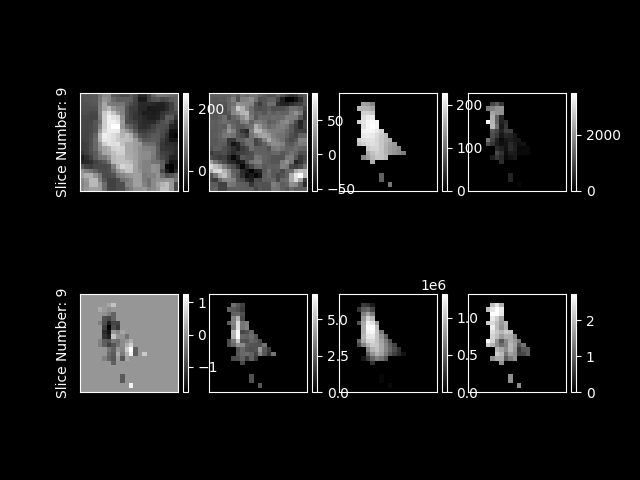

In [11]:
fig2, ax2 = plt.subplots(2,4)
y2 = seg_data
tracker3 = IndexTracker(ax2[0,0], y2)
tracker4 = IndexTracker(ax2[0,1], grad_data[0].astype('float'), 'hide labels')
tracker5 = IndexTracker(ax2[0,2], mean, 'hide labels')
tracker6 = IndexTracker(ax2[0,3], variance, 'hide labels')
tracker7 = IndexTracker(ax2[1,0], skewness)
tracker8 = IndexTracker(ax2[1,1], kurtosis, 'hide labels')
tracker9 = IndexTracker(ax2[1,2], energy, 'hide labels')
tracker10 = IndexTracker(ax2[1,3], entropy, 'hide labels')
fig2.canvas.mpl_connect('scroll_event', tracker3.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker4.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker5.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker6.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker7.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker8.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker9.onscroll)
fig2.canvas.mpl_connect('scroll_event', tracker10.onscroll)
plt.show()
plt.set_cmap('gray')
ax2[0,0].set_xlabel('QSM')
ax2[0,1].set_xlabel('Gradient')
ax2[0,2].set_xlabel('Mean')
ax2[0,3].set_xlabel('Variance')
ax2[1,0].set_xlabel('Skewness')
ax2[1,1].set_xlabel('Kurtosis')
ax2[1,2].set_xlabel('Energy')
ax2[1,3].set_xlabel('Entropy')
plt.style.use('dark_background')
fig2.suptitle('Some histogram feature maps of healthy right subthalmic nucleus');

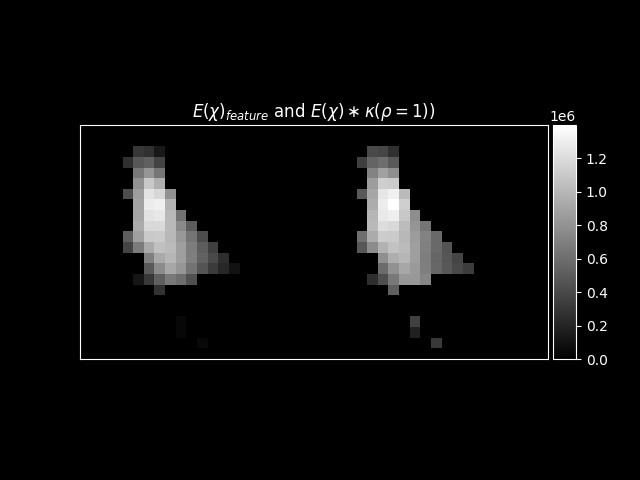

In [12]:
# Demonstrate equivalence with convolution of input QSM and 3x3x3 kernel of ones with pyradiomics function
# Basically, the QSM is downsampled then operated on
# Note most of the calculated features are nonlinear, so convolution and feature calculation cannot be interchanged

qsm_crop_np = sitk.GetArrayFromImage(qsm_crop_sitk)
sitk_crop_np =  sitk.GetArrayFromImage(seg_crop_sitk)
conv_out = ndimage.convolve(qsm_crop_np**2,np.ones((3,3,3)))
energy_conv = sitk_crop_np*(conv_out)
fig00, ax00 = plt.subplots(1,1)
tracker01 = IndexTracker(ax00, np.hstack((energy,energy_conv.swapaxes(0,2))),'hide labels')
fig00.canvas.mpl_connect('scroll_event', tracker01.onscroll)
ax00.set_title('$E(\chi)_{feature} \\ \mathrm{and} \\ E(\chi) \\ast \kappa(\\rho=1)$)');





In [13]:
# Extract some Gray Level Co-occurence Matrix (GLCM) features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeaturesByName(glcm=['Contrast', 'JointEnergy','JointEntropy'])
print('Enabled features:\n\t', extractor.enabledFeatures)
featureVector2 = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)


Enabled features:
	 {'glcm': ['Contrast', 'JointEnergy', 'JointEntropy']}


In [14]:
features2 = OrderedDict()
result2 = features2
Finalresult2=six.iteritems(result2)
for key, value in six.iteritems(featureVector2):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)

	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelBased': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 56ff1b286e23a1c84c52d08a35ae32e6d31103b7
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (512, 512, 352)
	diagnostics_Image-original_Mean: -29089.922570770435
	diagnostics_Image-original_Minimum: -32768.0
	diagnostics_Image-original_

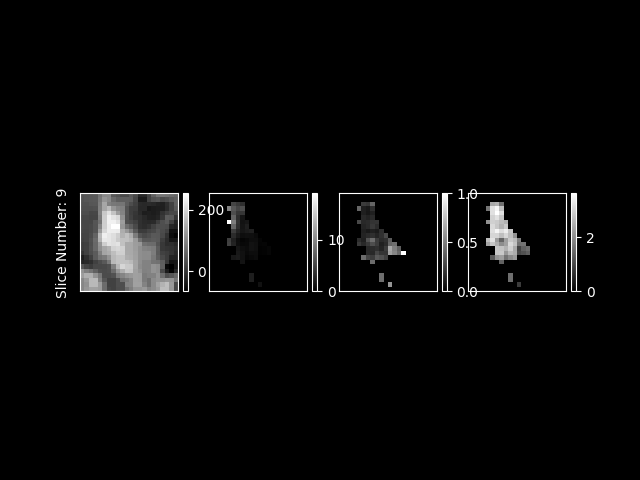

In [15]:
contrast, contrast_header = nrrd.read('original_glcm_Contrast.nrrd')
joint_energy, joint_energy_header = nrrd.read('original_glcm_JointEnergy.nrrd')
joint_entropy, joint_entropy_header = nrrd.read('original_glcm_JointEntropy.nrrd')

fig3, ax3 = plt.subplots(1,4)
y3 = seg_data
tracker11 = IndexTracker(ax3[0], y3)
tracker12 = IndexTracker(ax3[1], contrast, 'hide labels')
tracker13 = IndexTracker(ax3[2], joint_energy, 'hide labels')
tracker14 = IndexTracker(ax3[3], joint_entropy, 'hide labels')

fig3.canvas.mpl_connect('scroll_event', tracker11.onscroll)
fig3.canvas.mpl_connect('scroll_event', tracker12.onscroll)
fig3.canvas.mpl_connect('scroll_event', tracker13.onscroll)
fig3.canvas.mpl_connect('scroll_event', tracker14.onscroll)

plt.show()
plt.set_cmap('gray')
ax3[0].set_xlabel('QSM')
ax3[1].set_xlabel('Contrast')
ax3[2].set_xlabel('Joint Energy')
ax3[3].set_xlabel('Joint Entropy')

plt.style.use('dark_background')
fig3.suptitle('Some gray level co-occurence matrix feature maps of healthy right subthalmic nucleus');

In [ ]:
# Extract some Gray Level Run Length Matrix (GLRLM) features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeaturesByName(glrlm=['RunPercentage','ShortRunEmphasis','LongRunEmphasis','RunLengthNonUniformity'])
print('Enabled features:\n\t', extractor.enabledFeatures)
featureVector3 = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)

In [ ]:
features3 = OrderedDict()
result3 = features3
Finalresult3=six.iteritems(result3)
for key, value in six.iteritems(featureVector3):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)

In [ ]:
run_percentage, run_percentage_header = nrrd.read('original_glrlm_RunPercentage.nrrd')
short_run_emphasis, short_run_emphasis_header = nrrd.read('original_glrlm_ShortRunEmphasis.nrrd')
long_run_emphasis, long_run_emphasis_header = nrrd.read('original_glrlm_LongRunEmphasis.nrrd')
run_length_nonuniformity, run_length_nonuniformity_header = nrrd.read('original_glrlm_RunLengthNonUniformity.nrrd')


fig4, ax4 = plt.subplots(1,5)
y4 = seg_data
tracker15 = IndexTracker(ax4[0], y4)
tracker16 = IndexTracker(ax4[1], run_percentage, 'hide labels')
tracker17 = IndexTracker(ax4[2], short_run_emphasis, 'hide labels')
tracker18 = IndexTracker(ax4[3], long_run_emphasis, 'hide labels')
tracker19 = IndexTracker(ax4[4], run_length_nonuniformity, 'hide labels')

fig4.canvas.mpl_connect('scroll_event', tracker15.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker16.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker17.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker18.onscroll)
fig4.canvas.mpl_connect('scroll_event', tracker19.onscroll)

plt.show()
plt.set_cmap('gray')
ax4[0].set_xlabel('QSM')
ax4[1].set_xlabel('Run Percentage')
ax4[2].set_xlabel('Short Run Emphasis')
ax4[3].set_xlabel('Long Run Emphasis')
ax4[4].set_xlabel('Run Length Nonuniformity')

plt.style.use('dark_background')
fig4.suptitle('Some gray level run-length matrix feature maps of healthy right subthalmic nucleus');